In [15]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time

import sklearn.metrics as skm
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import Data Set

In [16]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True,transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True,transform=transform)

# transform to dataloaders
# batchsize    = 32
# train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader  = DataLoader(testset, batch_size=len(testset))

# Create the DL model

In [29]:
# create a class for the model
def createTheFMNISTNet():

  class fmnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      #self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      #x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = fmnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [30]:
# X,y = next(iter(test_loader))

# # Cheking the size
# print('Data shapes (train/test):')
# print( X.data.shape )

# # the range of pixel intensity values
# print('\nData value range:')
# print( (torch.min(X.data),torch.max(X.data)) )

In [31]:
# torch.squeeze(X).reshape(10000,28*28)

# Create a function that trains the model

In [32]:
# number of epochs
numepochs = 10
def function2trainTheModel(bs):
  
  # create a new model
  net,lossfun,optimizer = createTheFMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      
      # forward pass and loss
      yHat = net(torch.squeeze(X).reshape(bs,28*28))
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(torch.squeeze(X).reshape(10000,28*28))
      #torch.squeeze(X).reshape(32,28*28)
    # compare Target vs Prediction
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,yHat


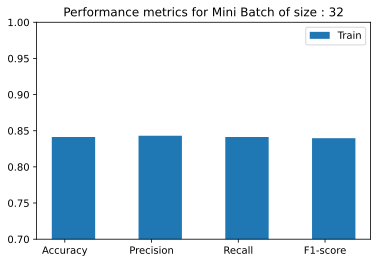

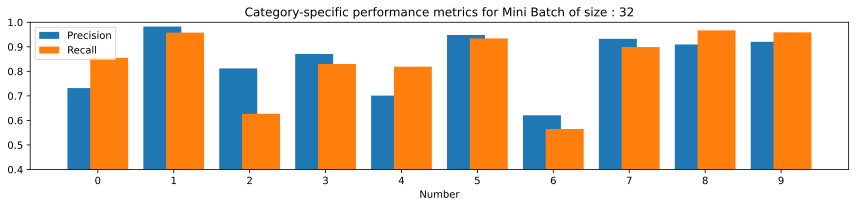

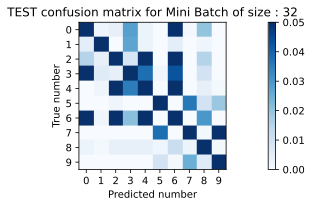

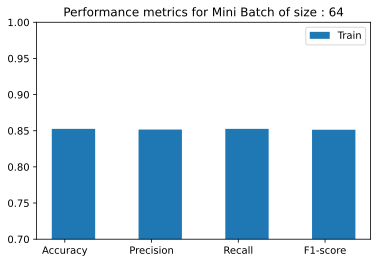

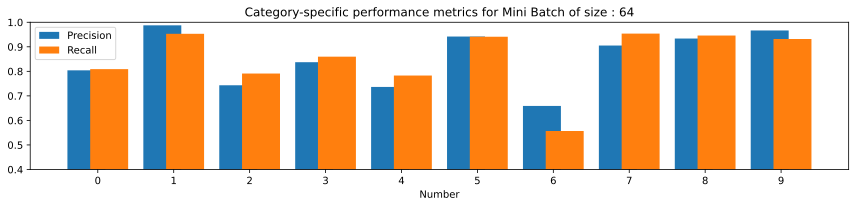

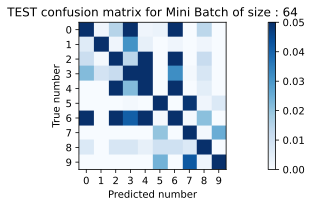

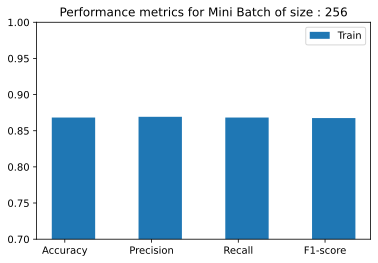

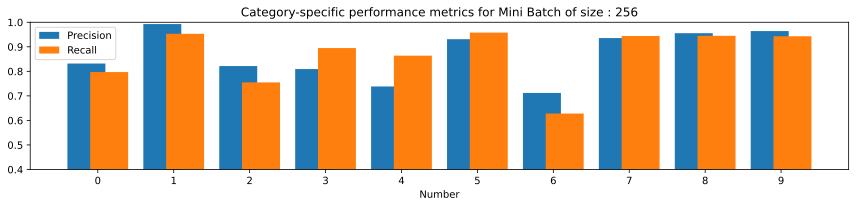

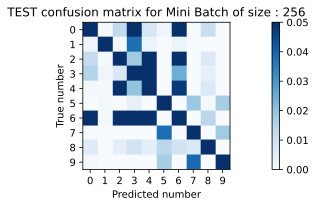

In [33]:
#~8 min in CPU
batchsizes = [32,64,256]
# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
LossesResultsTrain   = np.zeros((numepochs,len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

test_loader  = DataLoader(testset, batch_size=len(testset))
for bi in range(len(batchsizes)):
  starttime = time.process_time()
  train_loader = DataLoader(trainset,batch_size=batchsizes[bi],shuffle=True,drop_last=True)
  trainAcc,testAcc,losses,net,yHat = function2trainTheModel(batchsizes[bi])
  accuracyResultsTrain[:,bi] = trainAcc
  accuracyResultsTest[:,bi]  = testAcc
  LossesResultsTrain[:,bi] = losses
  comptime[bi] = time.process_time() - starttime
  # initialize vectors
  test_metrics  = [0,0,0,0]
  # test
  test_predictions = torch.argmax(yHat,axis=1)
  test_predictions
  test_metrics[0] = skm.accuracy_score (testset.targets,test_predictions)
  test_metrics[1] = skm.precision_score(testset.targets,test_predictions,average='weighted')
  test_metrics[2] = skm.recall_score   (testset.targets,test_predictions,average='weighted')
  test_metrics[3] = skm.f1_score       (testset.targets,test_predictions,average='weighted')
  #new plot
  plt.bar(np.arange(4)+.1,test_metrics,.5)
  plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
  plt.ylim([.7,1])
  plt.legend(['Train','Test'])
  plt.title('Performance metrics for Mini Batch of size : {}'.format(batchsizes[bi]))
  #new plot
  precision = skm.precision_score(testset.targets,test_predictions,average=None)
  recall    = skm.recall_score   (testset.targets,test_predictions,average=None)
  fig = plt.figure(figsize=(12,3))
  plt.bar(np.arange(10)-.15,precision,.5)
  plt.bar(np.arange(10)+.15,recall,.5)
  plt.xticks(range(10),range(10))
  plt.ylim([.4,1])
  plt.xlabel('Number')
  plt.legend(['Precision','Recall'])
  plt.title('Category-specific performance metrics for Mini Batch of size : {}'.format(batchsizes[bi]))
  #fig.suptitle('Mini Batch of size : {}'.format(batchsizes[bi]))
  plt.tight_layout()
  # Confusion matrices
  testConf  = skm.confusion_matrix(testset.targets,test_predictions,normalize='true')
  # confmat during TEST
  fig = plt.figure(figsize=(12,3))
  a = plt.imshow(testConf,cmap='Blues',vmax=.05)
  plt.xticks(range(10))
  plt.yticks(range(10))
  plt.title('TEST confusion matrix for Mini Batch of size : {}'.format(batchsizes[bi]))
  plt.xlabel('Predicted number')
  plt.ylabel('True number')
  fig.colorbar(a)
  #fig.suptitle('Mini Batch of size : {}'.format(batchsizes[bi]))
  plt.tight_layout()
  plt.show()


# Run the model and show the results!

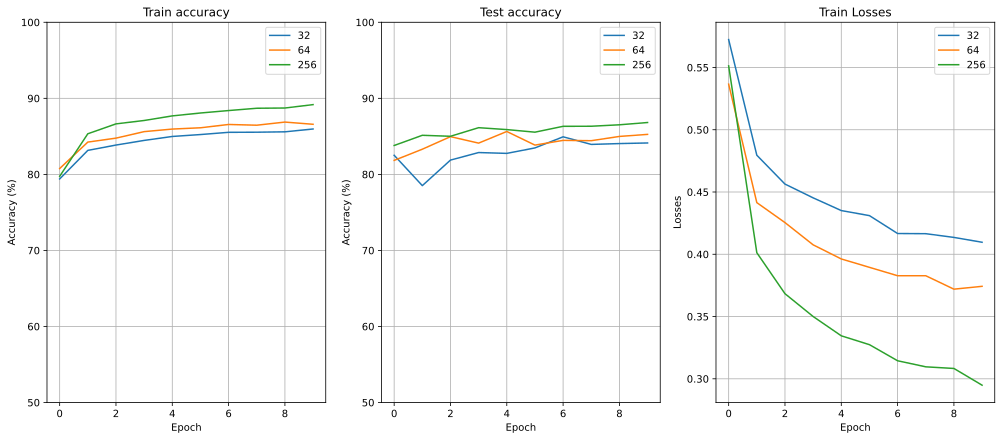

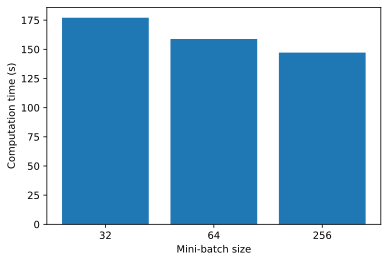

In [34]:
# build and train the model
#trainAcc,testAcc,losses,net,yHat = function2trainTheModel()


fig,ax = plt.subplots(1,3,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')
ax[2].plot(LossesResultsTrain)
ax[2].set_title('Train Losses')
# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

ax[2].legend(batchsizes)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Losses')
ax[2].grid()

plt.show()



# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()